In [1]:
%matplotlib inline
from __future__ import print_function
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt

C:\Users\joshu\Miniconda3\envs\tflab\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def conv_block(inputs, out_channels, name='conv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        conv = tf.contrib.layers.max_pool2d(conv, 2)
        return conv

In [4]:
def encoder(x, h_dim, z_dim, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        net = conv_block(x, h_dim, name='conv_1')
        net = conv_block(net, h_dim, name='conv_2')
        net = conv_block(net, h_dim, name='conv_3')
        net = conv_block(net, z_dim, name='conv_4')
        net = tf.contrib.layers.flatten(net)
        return net

In [5]:
def euclidean_distance(a, b):
    # a.shape = N x D # support (gives the prototype)
    # b.shape = M x D # querry
    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    # to make sure the dimensions become the same (broadcasting)
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [86]:
a = tf.truncated_normal([4,2])
b = tf.zeros([3,2])
N, D = tf.shape(a)[0], tf.shape(a)[1]
M = tf.shape(b)[0]
a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
a_tile = tf.reduce_mean(tf.square(a - b), axis=2)
log_soft = tf.nn.log_softmax(a_tile)
with tf.Session() as sess:
    print(sess.run(tf.shape(log_soft)))
    print(sess.run(log_soft))
# tf.Print(tf.shape(a_tile))

[4 3]
[[-1.0986123 -1.0986123 -1.0986123]
 [-1.0986123 -1.0986123 -1.0986123]
 [-1.0986123 -1.0986123 -1.0986123]
 [-1.0986123 -1.0986123 -1.0986123]]


In [6]:
n_epochs = 20
n_episodes = 100
n_way = 60
n_shot = 5
n_query = 5
n_examples = 20
im_width, im_height, channels = 28, 28, 1
h_dim = 64
z_dim = 64

In [14]:
# Load Train Dataset
root_dir = './data/omniglot'
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')
with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]
n_classes = len(train_classes)
print("number of classes: ", n_classes)
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(train_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        train_dataset[i, j] = im
print(train_dataset.shape)

number of classes:  4112
(4112, 20, 28, 28)


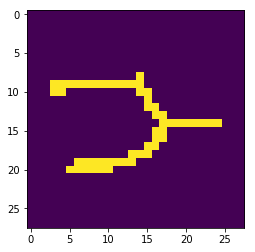

In [34]:
imgplot = plt.imshow(train_dataset[1001,2])

The author made the dimension of the `train_dataset` as follows
``` python
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
```
However, it seem, from inspecting the dataset, that `n_classes` is actually the number of all the samples in the dataset
___

In a second look. It looks like different rotations difine differenct classes since rotations are different for each line.

In [ ]:
x = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
q = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
x_shape = tf.shape(x)
q_shape = tf.shape(q)
num_classes, num_support = x_shape[0], x_shape[1]
num_queries = q_shape[1]
y = tf.placeholder(tf.int64, [None, None])
y_one_hot = tf.one_hot(y, depth=num_classes)
# here he collapses the number of classes and support into one as input to the encoding network.
emb_x = encoder(tf.reshape(x, [num_classes * num_support, im_height, im_width, channels]), h_dim, z_dim)
emb_dim = tf.shape(emb_x)[-1]
emb_x = tf.reduce_mean(tf.reshape(emb_x, [num_classes, num_support, emb_dim]), axis=1)
emb_q = encoder(tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels]), h_dim, z_dim, reuse=True)
# emb_q = encoder(tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels]), h_dim, z_dim, reuse=tf.AUTO_REUSE)
dists = euclidean_distance(emb_q, emb_x)
log_p_y = tf.reshape(tf.nn.log_softmax(-dists), [num_classes, num_queries, -1])
ce_loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, log_p_y), axis=-1), [-1]))
acc = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(log_p_y, axis=-1), y)))

In [8]:
train_op = tf.train.AdamOptimizer().minimize(ce_loss)

In [9]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [104]:
# np.arange(5)[:,np.newaxis]
np.tile(np.arange(5)[:,np.newaxis], (1,1)).astype(np.uint8)

array([[0],
       [1],
       [2],
       [3],
       [4]], dtype=uint8)

In [10]:
for ep in range(n_epochs):
    for epi in range(n_episodes):
        epi_classes = np.random.permutation(n_classes)[:n_way]
        support = np.zeros([n_way, n_shot, im_height, im_width], dtype=np.float32)
        query = np.zeros([n_way, n_query, im_height, im_width], dtype=np.float32)
        for i, epi_cls in enumerate(epi_classes):
            selected = np.random.permutation(n_examples)[:n_shot + n_query]
            support[i] = train_dataset[epi_cls, selected[:n_shot]]
            query[i] = train_dataset[epi_cls, selected[n_shot:]]
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
        _, ls, ac = sess.run([train_op, ce_loss, acc], feed_dict={x: support, q: query, y:labels})
        if (epi+1) % 50 == 0:
            print('[epoch {}/{}, episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(ep+1, n_epochs, epi+1, n_episodes, ls, ac))

[epoch 1/20, episode 50/100] => loss: 2.05681, acc: 0.69667
[epoch 1/20, episode 100/100] => loss: 1.31057, acc: 0.84333
[epoch 2/20, episode 50/100] => loss: 0.95323, acc: 0.85667
[epoch 2/20, episode 100/100] => loss: 0.77123, acc: 0.90667
[epoch 3/20, episode 50/100] => loss: 0.56138, acc: 0.93333
[epoch 3/20, episode 100/100] => loss: 0.56206, acc: 0.91667
[epoch 4/20, episode 50/100] => loss: 0.41580, acc: 0.95000
[epoch 4/20, episode 100/100] => loss: 0.32341, acc: 0.95333
[epoch 5/20, episode 50/100] => loss: 0.21081, acc: 0.98667
[epoch 5/20, episode 100/100] => loss: 0.23478, acc: 0.97333
[epoch 6/20, episode 50/100] => loss: 0.18931, acc: 0.96000
[epoch 6/20, episode 100/100] => loss: 0.25989, acc: 0.93333
[epoch 7/20, episode 50/100] => loss: 0.16271, acc: 0.97667
[epoch 7/20, episode 100/100] => loss: 0.18911, acc: 0.96000
[epoch 8/20, episode 50/100] => loss: 0.19383, acc: 0.96333
[epoch 8/20, episode 100/100] => loss: 0.16333, acc: 0.96333
[epoch 9/20, episode 50/100] => 

In [11]:
# Load Test Dataset
root_dir = './data/omniglot'
test_split_path = os.path.join(root_dir, 'splits', 'test.txt')
with open(test_split_path, 'r') as test_split:
    test_classes = [line.rstrip() for line in test_split.readlines()]
n_test_classes = len(test_classes)
test_dataset = np.zeros([n_test_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(test_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        test_dataset[i, j] = im
print(test_dataset.shape)

(1692, 20, 28, 28)


In [12]:
n_test_episodes = 1000
n_test_way = 20
n_test_shot = 5
n_test_query = 15

In [13]:
print('Testing...')
avg_acc = 0.
for epi in range(n_test_episodes):
    epi_classes = np.random.permutation(n_test_classes)[:n_test_way]
    support = np.zeros([n_test_way, n_test_shot, im_height, im_width], dtype=np.float32)
    query = np.zeros([n_test_way, n_test_query, im_height, im_width], dtype=np.float32)
    for i, epi_cls in enumerate(epi_classes):
        selected = np.random.permutation(n_examples)[:n_test_shot + n_test_query]
        support[i] = test_dataset[epi_cls, selected[:n_test_shot]]
        query[i] = test_dataset[epi_cls, selected[n_test_shot:]]
    support = np.expand_dims(support, axis=-1)
    query = np.expand_dims(query, axis=-1)
    labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
    ls, ac = sess.run([ce_loss, acc], feed_dict={x: support, q: query, y:labels})
    avg_acc += ac
    if (epi+1) % 50 == 0:
        print('[test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_test_episodes, ls, ac))
avg_acc /= n_test_episodes
print('Average Test Accuracy: {:.5f}'.format(avg_acc))

Testing...
[test episode 50/1000] => loss: 0.03256, acc: 0.99667
[test episode 100/1000] => loss: 0.12023, acc: 0.98000
[test episode 150/1000] => loss: 0.07153, acc: 0.98000
[test episode 200/1000] => loss: 0.05016, acc: 0.99000
[test episode 250/1000] => loss: 0.10391, acc: 0.97333
[test episode 300/1000] => loss: 0.16047, acc: 0.94667
[test episode 350/1000] => loss: 0.09679, acc: 0.96333
[test episode 400/1000] => loss: 0.04228, acc: 0.99000
[test episode 450/1000] => loss: 0.04014, acc: 0.98667
[test episode 500/1000] => loss: 0.11133, acc: 0.96333
[test episode 550/1000] => loss: 0.06174, acc: 0.99000
[test episode 600/1000] => loss: 0.04588, acc: 0.99000
[test episode 650/1000] => loss: 0.07874, acc: 0.97667
[test episode 700/1000] => loss: 0.09997, acc: 0.96333
[test episode 750/1000] => loss: 0.06412, acc: 0.98333
[test episode 800/1000] => loss: 0.03532, acc: 0.99000
[test episode 850/1000] => loss: 0.03986, acc: 0.99333
[test episode 900/1000] => loss: 0.04442, acc: 0.99000
